In [1]:
#Import the data.
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Earthquake = pd.read_csv("https://raw.githubusercontent.com/BuzzFeedNews/2015-03-earthquake-maps/master/data/earthquake_states.csv")
Earthquake.head()
Earthquake = Earthquake.dropna()
Earthquake=Earthquake.drop(['id','updated','type','geom'],axis=1)
Earthquake.sort_values(['mag'],axis = 0, ascending=True,inplace=True)
Earthquake.head()

,time,latitude,longitude,mag,place,state
105552,1978-06-14 19:44:33.4-04,33.500,-116.782,3.0,Southern California,California
61125,1998-01-26 06:00:53.63-05,37.037,-121.489,3.0,Northern California,California
61127,1998-01-26 04:32:31.87-05,62.220,-150.274,3.0,Central Alaska,Alaska
96756,1984-10-03 19:17:23.08-04,62.742,-143.714,3.0,Central Alaska,Alaska
23664,2008-11-08 11:31:54-05,33.498,-116.513,3.0,Southern California,California


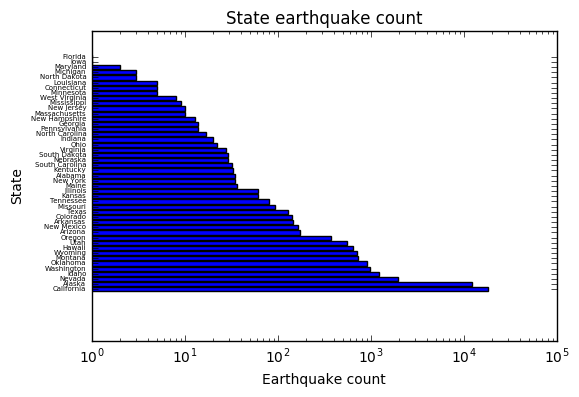

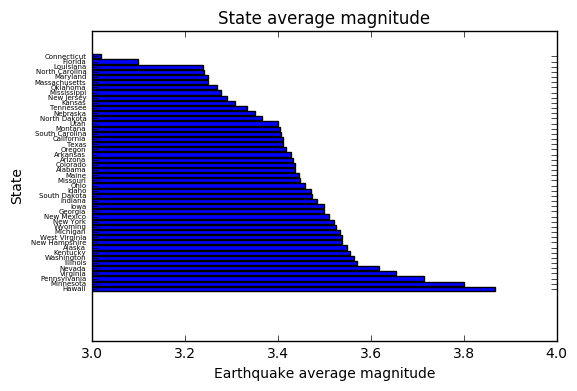

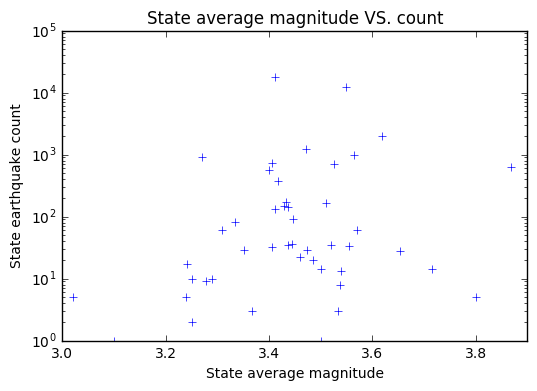

In [2]:
#Step2, analize the counts of earthquakes in different states.
Statecount = Earthquake.groupby(['state']).size().to_frame('count').reset_index()
Statecount.sort_values(['count'],axis=0,ascending=False,inplace=True)
stateaver = Earthquake[['state','mag']].groupby(['state']).mean().reset_index()
stateaver.columns=['state','avermag']
stateaver.sort_values(['avermag'],ascending=False,inplace=True)
state=pd.merge(Statecount, stateaver, on='state', how='inner')
state.sort_values(['count'],ascending=False, inplace=True)
plt.title('State earthquake count')
plt.barh(range(0,len(state)), state['count'], align='center')
plt.yticks(range(0,len(state)),state['state'], size=5)
plt.ylabel('State')
plt.xlabel('Earthquake count')
plt.xscale('log')
plt.show()
state.sort_values(['avermag'],ascending=False, inplace=True)
plt.title('State average magnitude')
plt.barh( range(0,len(state)), state['avermag'], align='center')
plt.yticks(range(0,len(state)),state['state'], size=5)
plt.ylabel('State')
plt.xlabel('Earthquake average magnitude')
plt.xlim([3, 4])
plt.show()
plt.plot(state['avermag'],state['count'],'+')
plt.yscale('log')
plt.title('State average magnitude VS. count')
plt.xlabel('State average magnitude')
plt.ylabel('State earthquake count')
plt.show()

With these plots, we can say that there is no obvious relation between a state's average magnitude and its earthquake count. California
has the most earthquakes in US, and Hawaii has the highest state average magnitude in US. It is not very practical to compare these two
factors and figure out which one is more important for people to watch out, so I invent a new variable called total magnitude, which is 
calculated by summing up all the magnitudes of earthquakes together, and it can also be calculated by State average magnitude times state
earthquake count.

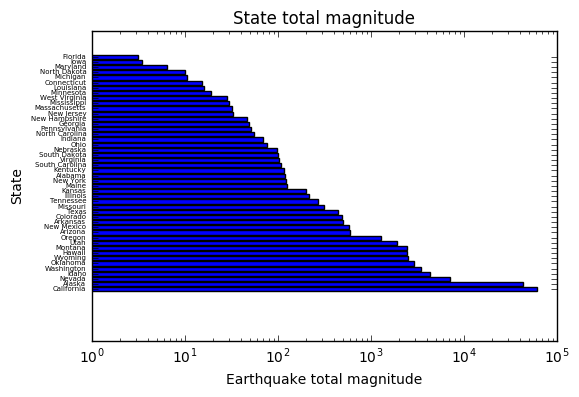

In [3]:
state['totalmag']=state['avermag']*state['count']
state.sort_values(['totalmag'],ascending=False, inplace=True)
plt.title('State total magnitude')
plt.barh( range(0,len(state)), state['totalmag'], align='center')
plt.yticks(range(0,len(state)),state['state'], size=5)
plt.ylabel('State')
plt.xlabel('Earthquake total magnitude')
plt.xscale('log')
plt.show()

We can see that the result of this new variable is pretty close to the result of state earthquake count. And this is reasonable because the average magnitudes of all these states are all in the range of 3 to 4, so the influence of state average magnitude on this total magnitude is really limited.

   cate  count
0     3  33888
1     4   5472
2     5    578
3     6     52
4     7     10


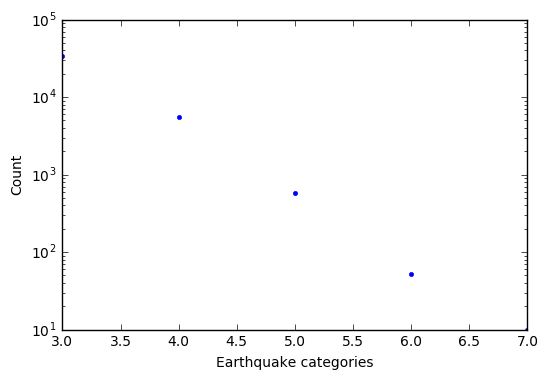

In [4]:
Earthquake['cate']=Earthquake['mag'].apply(int)
catecount=Earthquake[['cate']].groupby(['cate']).size().to_frame('count').reset_index()
print(catecount)
plt.plot(catecount['cate'],catecount['count'],'.')
plt.xlabel('Earthquake categories')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

It seems that there is a linear relation between earthquake category and the denary logarithm of its count. So let's see how well it works.

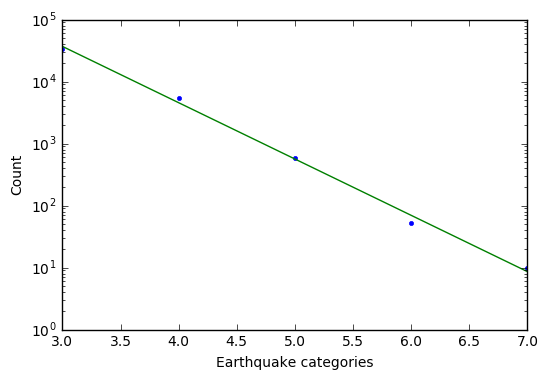

In [5]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(catecount[['cate']], catecount['count'].apply(np.log10))
plt.plot(catecount['cate'],catecount['count'],'.')
plt.plot(catecount['cate'],np.power(10,reg.predict(catecount[['cate']])),'-')
plt.xlabel('Earthquake categories')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [6]:
Earthquake[['date','dtime']] = Earthquake['time'].str.split(' ',1,expand=True)
Earthquake[['year','month','day']] = Earthquake['date'].str.split('-',2,expand=True)
yearaver = Earthquake[['year','mag']].groupby(['year']).mean().reset_index()
yearaver.sort_values(['mag'],ascending=True,inplace=True)
monthaver = Earthquake[['month','mag']].groupby(['month']).mean().reset_index()
monthaver.sort_values(['mag'],ascending=True,inplace=True)
Earthquake.sort_values(['mag'],axis = 0, ascending=False,inplace=True)
Earthquake.head()

,time,latitude,longitude,mag,place,state,cate,date,dtime,year,month,day
47447,2002-11-03 22:12:41-05,63.517,-147.444,7.9,Central Alaska,Alaska,7,2002-11-03,22:12:41-05,2002,11,03
84839,1992-06-28 11:57:34.12-04,34.201,-116.436,7.3,Southern California,California,7,1992-06-28,11:57:34.12-04,1992,06,28
74154,1992-06-28 11:57:34.12-04,34.201,-116.436,7.3,Southern California,California,7,1992-06-28,11:57:34.12-04,1992,06,28
89261,1989-10-18 00:04:15.24-04,37.036,-121.883,7.2,Northern California,California,7,1989-10-18,00:04:15.24-04,1989,10,18
74638,1992-04-25 18:06:04.21-04,40.368,-124.316,7.2,Northern California,California,7,1992-04-25,18:06:04.21-04,1992,04,25


In [7]:
map = folium.Map(location=[47, -130], zoom_start=3)
for i, row in Earthquake.iterrows():
    if row['mag'] > 7:
        folium.CircleMarker([row['latitude'], row['longitude']],radius=row['mag'],popup='Magnitude: '+str(row['mag'])+' Place: '+row['place']+' Time: '+str(row['time']),color='black',fill_color='black').add_to(map)
    elif row['mag'] > 6:
        folium.CircleMarker([row['latitude'], row['longitude']],radius=row['mag'],popup='Magnitude: '+str(row['mag'])+' Place: '+row['place']+' Time: '+str(row['time']),color='red',fill_color='red').add_to(map)
    elif row['mag'] > 5:
        folium.CircleMarker([row['latitude'], row['longitude']],radius=row['mag'],popup='Magnitude: '+str(row['mag'])+' Place: '+row['place']+' Time: '+str(row['time']),color='yellow',fill_color='yellow').add_to(map)
map

In [8]:
stateyearcount = Earthquake[['year','state']].groupby(['year','state']).size().to_frame('count').reset_index()
stateyearcount.sort_values(['count'],axis = 0, ascending=False,inplace=True)
moststateyear=stateyearcount.iloc[0]
print('the highest count of Earthquake of one state in a year: ')
print(str(moststateyear['count'])+' times, in '+str(moststateyear['state'])+', in '+str(moststateyear['year']))

the highest count of Earthquake of one state in a year: 
2426 times, in California, in 1992


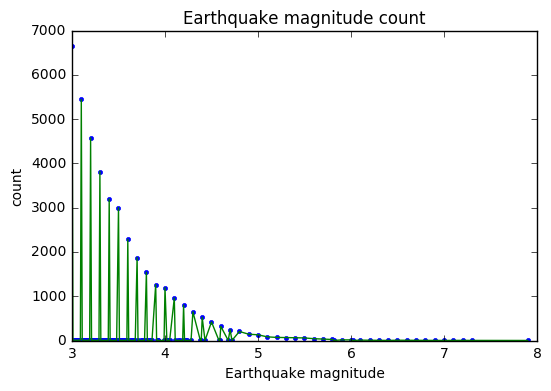

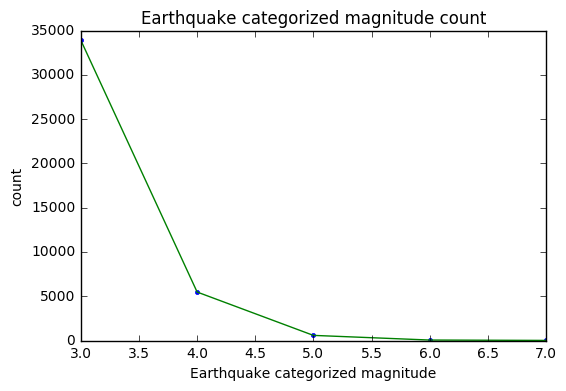

In [9]:
magcount = Earthquake[['mag']].groupby(['mag']).size().to_frame('count').reset_index()
plt.title('Earthquake magnitude count')
plt.plot(magcount['mag'],magcount['count'],'.')
plt.plot(magcount['mag'],magcount['count'],'-')
plt.xlabel('Earthquake magnitude')
plt.ylabel('count')
plt.show()
catecount = Earthquake[['cate']].groupby(['cate']).size().to_frame('count').reset_index()
plt.title('Earthquake categorized magnitude count')
plt.plot(catecount['cate'],catecount['count'],'.')
plt.plot(catecount['cate'],catecount['count'],'-')
plt.xlabel('Earthquake categorized magnitude')
plt.ylabel('count')
plt.show()

Looking at the raw data, we can easily figure out the raw data is really abnormal. When the magnitude is less than 5,
the occurence of earthquakes with a magnitude of a multiple of 0.1 is significantly higher than the occurence of earthquakes with other magnitudes. So, the data cannot show a real distribution of earthquake magnitudes in US.
Then what should I do to reveal the true distribution?
There are two possible ideas, one is to split some of the sharp peaks to their neighboring ranges, so that we may lower those peaks and get
a more smooth line. I can split those peaks with normal distribution into its neighboring range with a length of 1, or I can split it evenly
in that range. But this may bring more uncertainties into the dataset, and uncertainties are not good for data analysis.
Another way is to round the magnitudes to 0.1 level, so that we can ignore those special cases, and look at the big picture of the data.
Compared with the previous idea, this one is much easier, all I need to do is round up the maginitudes. 

regression model for rounded magnitude vs. count:


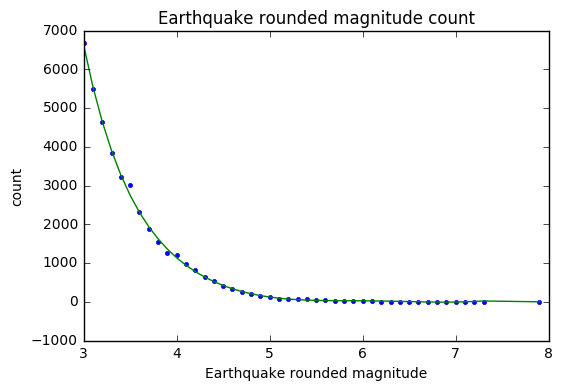

In [10]:
magcount['roundmag']=round(magcount['mag'],1)
roundcount = magcount[['roundmag','count']].groupby(['roundmag']).sum().reset_index()
print('regression model for rounded magnitude vs. count:')
plt.title('Earthquake rounded magnitude count')
z = np.poly1d(np.polyfit(roundcount['roundmag'],roundcount['count'],7))
d = roundcount['roundmag']
plt.plot(roundcount['roundmag'],roundcount['count'],'.')
plt.plot(d,z(d),'-')
plt.xlabel('Earthquake rounded magnitude')
plt.ylabel('count')
plt.show()

This regression looks fine for now, but we need to make sure that beyond 8, the model can still show reasonable result, for example, the count of any kind of earthquake cannot be less than 0. Knowing that the worst earthquake happened in the history of US has a magnitude of 9.2, we need to make sure that the curve beyond 8 should be decreasing and can't below 0. So first, let's check this model when we extend it to 10.

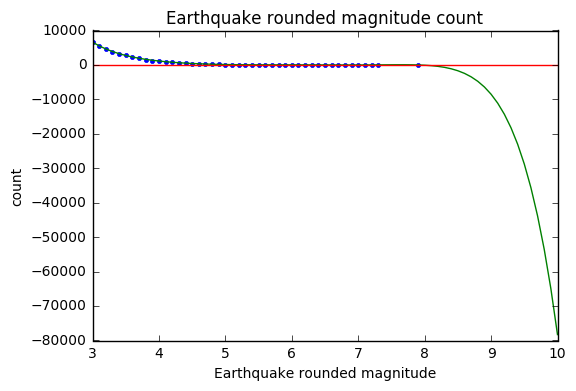

In [11]:
plt.title('Earthquake rounded magnitude count')
z = np.poly1d(np.polyfit(roundcount['roundmag'],roundcount['count'],7))
d = roundcount['roundmag']
plt.plot(roundcount['roundmag'],roundcount['count'],'.')
a = np.linspace(3.0, 10.0, num = 71)
plt.plot(a,z(a),'-')
b = np.zeros(71)
plt.plot(a, b, '-')
plt.xlabel('Earthquake rounded magnitude')
plt.ylabel('count')
plt.show()

We can see that the regression curve goes under the 0 standard line after it reaches about 8.3. So, this model is not good enough. To make sure the model is correct before it reaches 10, we need to add some 0 point to fix it. For this dataset, we need to add 0 for rounded magnitude 8, 9, and 10.

regression model for rounded magnitude vs. count:
the parameters of the model:
[ -6.01437364e-01   2.87470392e+01  -5.82964983e+02   6.51320451e+03
  -4.34020296e+04   1.73035455e+05  -3.83613919e+05   3.66409530e+05]


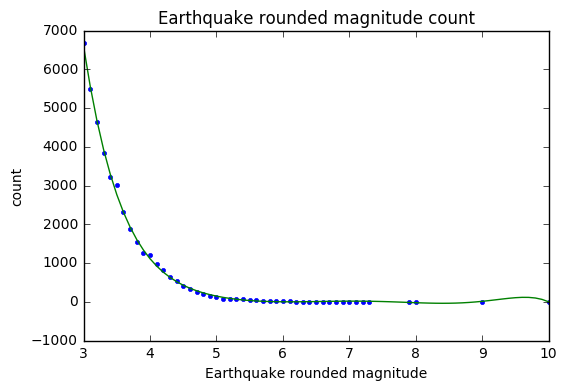

In [12]:
addup0 = pd.DataFrame([[8, 0], [9, 0], [10, 0]], columns=roundcount.columns)
roundcount = roundcount.append(addup0, ignore_index = True)
print('regression model for rounded magnitude vs. count:')
plt.title('Earthquake rounded magnitude count')
model = np.polyfit(roundcount['roundmag'],roundcount['count'],7)
print('the parameters of the model:')
print(model)
z = np.poly1d(model)
d = np.linspace(3.0, 10.0, num = 71)
plt.plot(roundcount['roundmag'],roundcount['count'],'.')
plt.plot(d,z(d),'-')
plt.xlabel('Earthquake rounded magnitude')
plt.ylabel('count')
plt.show()

Now, this model is valid for all magnitude between 3 to 10.